# Env

In [ ]:
!pip install pandas numpy matplotlib torch torchmetrics transformers scikit-learn nltk seaborn praw bertopic hdbscan umap-learn sentence-transformers

In [2]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.18.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.18.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import BertModel, BertTokenizer,AutoTokenizer, AutoModelForSequenceClassification, pipeline
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, BatchNormalization, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import seaborn as sns

import praw
import datetime
import time
import csv
import requests
import json
import multiprocessing
import os
from dateutil.relativedelta import relativedelta

import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="praw")

In [2]:
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/train.tsv'
LOC = '/content/drive/My Drive/Colab Notebooks/'
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def open_data(filepath):
  df = pd.read_csv(filepath, sep='\t')
  return df

In [4]:
def store_data(data, loc, filename):
  df = pd.DataFrame(data)
  filepath = os.path.join(loc, filename)
  df.to_csv(filepath, sep='\t', index=False, mode='a', header=not os.path.exists(filepath))

# Data Collection
Using PullPushAPI to retrieve posts and PRAW for their comments from r/canada, r/OnGuardForThee and r/CanadaPolitics in the last year.


In [ ]:
DELAY_SEC = 2
DELAY_FATAL = 60

## Retrieve posts within last year

### Collect
We collect posts with a minimum positive score to indicate posts with high engagement and, therefore, likely many comments.

In [ ]:
SUBREDDITS = ['canada', 'onguardforthee', 'CanadianPolitics', 'ontario', 'alberta']
SCORE = 100
BEGIN_DATE_START = 1709251200
BEGIN_DATE_SPAN = 1711843200
END_DATE = 1740960000
QUERIES= ['liberals', 'conservatives', 'ndp', 'poilievre', 'trudeau', 'carney', 'singh']
SIZE = 100
POSTS_FILENAME = 'posts.tsv'

In [ ]:
def get_posts(subreddit, score, start_date, end_date, query, size):
    PULLPUSH_URL = (
        f'https://api.pullpush.io/reddit/submission/search'
        f'?html_decode=True&subreddit={subreddit}&score=%3E{score}'
        f'&since={start_date}&until={end_date}&q={query}&size={size}'
    )
    response = requests.get(PULLPUSH_URL)

    if response.status_code == 200:
      return response.json()
    else:
      print(f'Request failed with status code {response.status_code}')
      print(response.text)
      return -1

def parse_posts(data):
  parsed = []
  data = data["data"]
  for post in data:
    parsed.append({
      "id": post["id"],
      "created_utc": datetime.datetime.utcfromtimestamp(post["created_utc"]).strftime('%Y-%m'),
      "subreddit": post["subreddit"],
      "title": post["title"],
    })
  return parsed

def update_timestamp(timestamp):
  dt = datetime.datetime.utcfromtimestamp(timestamp)
  updated_dt = dt + relativedelta(months=1)
  return int(updated_dt.timestamp())

total_tasks = len(SUBREDDITS) * len(QUERIES)
with tqdm(total=total_tasks, desc="Processing Subreddits and Queries") as pbar:
  current_date = BEGIN_DATE_START
  curr_span = BEGIN_DATE_SPAN
  while curr_span < END_DATE:
    for subreddit in SUBREDDITS:
      for query in QUERIES:
        data = get_posts(subreddit, SCORE, current_date, curr_span, query, SIZE)
        time.sleep(DELAY_SEC)
        if data == -1:
          print('Taking a 1 min break...')
          time.sleep(DELAY_FATAL)
          print('Trying again...')
          data = get_posts(subreddit, SCORE, current_date, curr_span, query, SIZE)
          if data == -1:
            break
        parsed = parse_posts(data)
        store_data(parsed, LOC, POSTS_FILENAME)
    current_date = update_timestamp(current_date)
    curr_span = update_timestamp(curr_span)
    pbar.update(1)
  print("Data collection completed.")

### Pre-clean
We rmove duplicate posts by ID. Posts with the same title in different subreddits are inherently unqiue so are kept. We then filter out unrelated posts with a rejection list as the subreddits may contain provincial-related data.

In [ ]:
REJECT_FILTERS = [
    'alberta', 'calgary', 'smith',
    'british', 'columbia', 'BC', 'eby',
    'manitoba', 'gill',
    'new', 'brunswick', 'NB', 'arisman',
    'newfoundland', 'labrador', 'furey',
    'nova', 'scotia', 'mcneil',
    'ontario', 'toronto', 'ford',
    'prince', 'edward', 'island', 'king',
    'quebec', 'QC', 'leger',
    'saskatchewan', 'moe',
    'northwest', 'territories', 'mcneal',
    'nunavut', 'ivens',
    'yukon', 'frost'
]

In [ ]:
# Remove duplicates
filepath = os.path.join(LOC, 'posts.tsv')
df = open_data(filepath)
df_clean = df.drop_duplicates(subset=['id'])
df_clean.to_csv(filepath, sep='\t', index=False)
print(f"Number of duplicates removed: {len(df) - len(df_clean)}")

Number of duplicates removed: 1206


In [ ]:
# Filter rejects
filepath = os.path.join(LOC, 'posts.tsv')
df = open_data(filepath)
df_clean = df[~df["title"].str.contains('|'.join(REJECT_FILTERS), case=False, na=False)]
df_clean.to_csv(filepath, sep='\t', index=False)
print(f"Number of rejects removed: {len(df) - len(df_clean)}")

Number of rejects removed: 1093


## Retrieve comments for each post

### Collect
We collect all top-level comments from each post or the most upvoted 1000 comments, whichever comes first.  

In [ ]:
reddit = praw.Reddit(
  client_id="",
  client_secret="",
  user_agent="",
  check_for_async=False
)

In [ ]:
import concurrent.futures

def get_comments(post_id):
    try:
        submission = reddit.submission(id=post_id)
        submission.comment_sort = "top"
        submission.comments.replace_more(limit=0)

        comments = [
            {
                "id": comment.id,
                "associated_post": post_id,
                "body": comment.body,
                "score": comment.score
            }
            for comment in submission.comments.list()
        ]
        return comments

    except Exception as e:
        print(f"Error fetching comments for {post_id}: {e}")
        return -1

def process_post(row):
    post_id = row['id']
    date = row['created_utc']

    comments = get_comments(post_id)
    if comments == -1:
        print(f'Taking a {DELAY_FATAL} sec break...')
        time.sleep(DELAY_FATAL)
        print('Trying again...')
        comments = get_comments(post_id)
        if comments == -1:
            return None  # Skip this post if it fails again

    store_data(comments, f'{LOC}/comments', f'{date}.tsv')

def main():
    filepath = os.path.join(LOC, 'posts.tsv')
    df = open_data(filepath)

    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        list(tqdm(executor.map(process_post, [row for _, row in df.iterrows()]), total=len(df), desc="Collecting comments:"))

    print("Data collection completed.")

if __name__ == "__main__":
    main()

Error fetching comments for 1hx16u1: received 429 HTTP response
Taking a 60 sec break...


Error fetching comments for 1hwr412: received 429 HTTP response
Taking a 60 sec break...
Error fetching comments for 1hxv7nd: received 429 HTTP response
Taking a 60 sec break...


In [ ]:
filepath = os.path.join(LOC, 'comments')
total_rows = 0
for filename in os.listdir(filepath):
  if filename.endswith('.tsv'):
    df = open_data(os.path.join(filepath, filename))
    df.to_csv(os.path.join(filepath, filename), sep='\t', index=False)
    total_rows += len(df)
print(f"Total number of comments: {total_rows}")

Total number of comments: 487658


### Pre-clean
We utilize our keyword selection criteria to filter out unrelated comments. We remove null comments as well.

In [ ]:
KEYWORDS = [
    # Political leaders and parties
    'justin', 'trudeau', 'pierre', 'poilievre', 'jagmeet', 'singh',
    'mark', 'carney', 'ndp', 'new', 'democrats', 'party', 'new', 'democratic', 'party', 'ndp',
    'liberal', 'party', 'of', 'canada', 'liberal', 'party', 'liberals', 'lpc', 'liberals', 'liberal',
    'conservative', 'party', 'of', 'canada', 'conservative', 'party', 'conservatives', 'cpc', 'pc',
    'bloc', 'quebecois', 'bloc', 'green', 'party', 'of', 'canada', 'greens', 'green', 'gpc', 'green', 'party',
    'people’s', 'party', 'of', 'canada', 'ppc', 'peoples', 'party', 'socialist', 'socialism',

    # Election-related terms
    'election', 'polls', 'polling', 'campaign', 'voting', 'votes', 'voter', 'turnout', 'election', 'results',
    'election', 'day', 'election', 'campaign', 'ballots', 'voter', 'suppression', 'election', 'fraud',
    'polling', 'stations', 'early', 'voting', 'advance', 'polls', 'voter', 'registration', 'voter', 'id',

    # Federal issues and policies
    'carbon', 'tax', 'tax', 'carbon', 'climate', 'change', 'environment', 'greenhouse', 'gases', 'carbon', 'emissions',
    'immigration', 'refugees', 'canadian', 'immigration', 'border', 'control', 'economic', 'policies',
    'health', 'care', 'medicare', 'affordable', 'housing', 'indigenous', 'rights', 'reconciliation',
    'infrastructure', 'tax', 'reform', 'budget', 'federal', 'budget', 'debt', 'deficit', 'balanced', 'budget',
    'canadian', 'sovereignty', 'trade', 'policies', 'international', 'relations', 'foreign', 'policy', 'NAFTA', 'USMCA',

    # General political terms
    'policy', 'policies', 'platform', 'agenda', 'governance', 'government', 'leadership', 'political', 'party',
    'partisan', 'partisanship', 'democracy', 'elections', 'canada', 'canadian', 'constitution', 'parliament',
    'house', 'of', 'commons', 'senate', 'pm', 'prime', 'minister', 'opposition', 'backbencher', 'cabinet',
    'minister', 'conservative', 'liberal', 'ndp', 'green', 'vote', 'splitting', 'majority', 'minority',

    # Election events and dates
    '2023', 'election', '2025', 'election', '2021', 'election', 'election', 'results', 'voter', 'turnout', 'election', 'day',

    # Miscellaneous
    'activism', 'political', 'campaigns', 'voting', 'rights', 'media', 'bias', 'fake', 'news', 'news', 'coverage', 'election', 'integrity',
    'debates', 'town', 'halls', 'policy', 'speeches', 'election', 'strategy', 'campaign', 'trail', 'all-candidates', 'meeting'
]

In [ ]:
keywords_pattern = r'(?:' + '|'.join([re.escape(keyword) for keyword in KEYWORDS]) + r')\b'

filepath = os.path.join(LOC, 'comments')
savepath = os.path.join(LOC, 'comments/preclean')
total_remaining = 0

for filename in os.listdir(filepath):
  if filename.endswith('.tsv'):
    df = open_data(os.path.join(filepath, filename))

    # Remove duplicate IDs
    df_clean = df.drop_duplicates(subset=['id'])

    # Remove [deleted] and [removed] keywords
    df_clean['body'] = df_clean['body'].astype(str)
    df_clean = df_clean[~df_clean['body'].str.contains('\[deleted\]|\[removed\]', na=False)]

    # Apply keyword matching via regex (vectorized operation)
    df_clean = df_clean[df_clean['body'].str.contains(keywords_pattern, case=False, na=False)]

    df_clean.to_csv(os.path.join(savepath, filename), sep='\t', index=False)

    removed_count = len(df) - len(df_clean)
    print(f"Number of comments removed from {filename}: {removed_count}")

    total_remaining += len(df_clean)

print('Comments remaining:', total_remaining)

Number of comments removed from 2024-03.tsv: 11586
Number of comments removed from 2024-04.tsv: 12961
Number of comments removed from 2024-05.tsv: 10669
Number of comments removed from 2024-06.tsv: 8786
Number of comments removed from 2024-07.tsv: 7367
Number of comments removed from 2024-08.tsv: 9302
Number of comments removed from 2024-09.tsv: 10643
Number of comments removed from 2024-10.tsv: 12170
Number of comments removed from 2024-11.tsv: 9185
Number of comments removed from 2024-12.tsv: 15694
Number of comments removed from 2025-01.tsv: 21842
Number of comments removed from 2025-02.tsv: 25644
Comments remaining: 331809


# Data Sanitization and Preparation
Removes stopwords, handles special characters, and applies stemming and lemmatization. Encodes numerically to make use of in NN. Tokenizes text into meaninful units and pads/truncates for uniform input length (max token: 512).

## Cleaning

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def normalize_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = lemmatizer.lemmatize(word, wordnet.VERB)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

def clean_text(text):
    text = str(text)
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

def clean(df):
    tqdm.pandas(desc='Cleaning text')
    df['body'] = df['body'].progress_apply(clean_text)
    print(df.head())
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Apply to precleaned comments
filepath = os.path.join(LOC, 'comments/preclean')
df_clean = pd.DataFrame()

for filename in os.listdir(filepath):
  if filename.endswith('.tsv'):
    df = open_data(os.path.join(filepath, filename))
    df_clean = clean(df)
    store_data(df, f'{LOC}/processed', f'{filename}')

Cleaning text: 100%|██████████| 26069/26069 [00:14<00:00, 1763.79it/s]


        id associated_post                                               body  \
0  kx03jer         1bq1xzc  caf break every metric even throw bag money an...   
1  kwzomlb         1bq1xzc  shock anyone trudeau tell vet lose leg serve a...   
2  kwzuwr5         1bq1xzc  spend money defence something serious people r...   
3  kwzs7h7         1bq1xzc  canada people tend hate objective reality henc...   
4  kwzuoxs         1bq1xzc  vote national referendum necessary either pay ...   

   score  
0     80  
1     77  
2     24  
3     23  
4     13  


Cleaning text: 100%|██████████| 27575/27575 [00:15<00:00, 1744.36it/s]


        id associated_post                                               body  \
0  l1409ts         1ccacmf  lol jagmeet never die hill would require backb...   
1  l141zyp         1ccacmf              hill jagmeet die mount saint pension    
2  l141abo         1ccacmf  imagine jagmeet spineless body roll hill like ...   
3  l14097k         1ccacmf  kinda shock singh would ok 200 amount whole po...   
4  l1467sb         1ccacmf       ndp even pretend support work class anymore    

   score  
0     90  
1     58  
2     59  
3     48  
4     25  


Cleaning text: 100%|██████████| 21271/21271 [00:10<00:00, 2079.03it/s]


        id associated_post                                               body  \
0  l60s1zr         1d2je1x  post appear relate province territory canada r...   
1  l60wxjn         1d2je1x  progressive conservative candidate lin paddock...   
2  l61hkle         1d2je1x  snatch rather strong word liberals hand seat a...   
3  l61q9ub         1d2je1x  newfoundlander settle b ys provincial election...   
4  l61ofuo         1d2je1x             point cpc could campaign win election    

   score  
0      1  
1     79  
2     48  
3     21  
4     15  


Cleaning text: 100%|██████████| 19230/19230 [00:10<00:00, 1764.47it/s]


        id associated_post                                               body  \
0  laqm3qc         1dqu2qh                      double stupidity liberal way    
1  laqmpfq         1dqu2qh              agree enough immigration yet problem    
2  laqz0yn         1dqu2qh  yes young people still afford food house achie...   
3  lar713w         1dqu2qh  see trudeau burn house type guy go create lot ...   
4  laqnvj5         1dqu2qh  country scream feedback time plug ears scream ...   

  score  
0   297  
1   110  
2    34  
3    28  
4    22  


Cleaning text: 100%|██████████| 14931/14931 [00:08<00:00, 1694.93it/s]


        id associated_post                                               body  \
0  lep7f4m         1eb06wb  probably wont change course current cohort lib...   
1  lep9lxe         1eb06wb  liberal crew elect complete bumfinger captain ...   
2  lepcugt         1eb06wb  watch week steong party democrats oust sit pre...   
3  lepmkab         1eb06wb  guy ship already crash rock time change course...   
4  leqa3ov         1eb06wb  want 12 orange juice back oh days much simpler...   

   score  
0    146  
1     39  
2     15  
3     13  
4      6  


Cleaning text: 100%|██████████| 18552/18552 [00:09<00:00, 1920.01it/s]


        id associated_post                                               body  \
0  lkkh1a7         1f4bvgi  leader con pp gonna shit immigration sponsor l...   
1  lkkhftt         1f4bvgi  pierre decrease immigration none major party c...   
2  lkl38pt         1f4bvgi  protest indian international students want get...   
3  lkk9agn         1f4bvgi  pierre never gonna win cpc make mistake vote p...   
4  lklsvib         1f4bvgi  keep 70k international students protest deport...   

   score  
0    137  
1     83  
2     81  
3     26  
4     24  


Cleaning text: 100%|██████████| 24325/24325 [00:12<00:00, 1901.80it/s]


        id associated_post                                               body  \
0  lph9et6         1fs22p0  would enormous wealth transfer wealthiest gene...   
1  lph8rbq         1fs22p0  liberals already explode deficit reckless susp...   
2  lphyswn         1fs22p0  bloc go push push push things anticipation ele...   
3  lpho506         1fs22p0  odds everything oas benefit system already mas...   
4  lphdvy9         1fs22p0  dislike political conversations contain facts ...   

   score  
0    186  
1     55  
2     36  
3     34  
4     26  


Cleaning text: 100%|██████████| 25529/25529 [00:14<00:00, 1819.35it/s]


        id associated_post                                               body  \
0  luf8njf         1gf6pz9                              trudeau must go like    
1  luf9bgz         1gf6pz9                        ample reason right get rid    
2  lufqpyh         1gf6pz9  exactly like trump get upset biden drop poilie...   
3  lufcdub         1gf6pz9  monkey could beat trudeau election pierre afra...   
4  lufac71         1gf6pz9               pierre nothing besides anti trudeau    

   score  
0    849  
1    471  
2    270  
3    167  
4     67  


Cleaning text: 100%|██████████| 19002/19002 [00:09<00:00, 2071.12it/s]


        id associated_post                                               body  \
0  lzjuahg         1h2k803  curious kind nightmare would point sale update...   
1  lzjtlh0         1h2k803  liberals ndp great issue help canadians look s...   
2  lzjw0au         1h2k803  part pause spend lead start intentionally hold...   
3  lzjw7fg         1h2k803  temporary tax break joke retailers go recover ...   
4  lzjvlli         1h2k803  bs temp tax relief headaches store use tax fun...   

   score  
0    117  
1     44  
2     31  
3     17  
4     12  


Cleaning text: 100%|██████████| 33814/33814 [00:18<00:00, 1825.62it/s]


        id associated_post                                               body  \
0  m4eh0io         1hp3p2g  urgent year ago point lot merit let go ship su...   
1  m4ehfw1         1hp3p2g  let election time national crisis lpc concern ...   
2  m4eg08k         1hp3p2g  whole caucus need sweep support government 9 y...   
3  m4eiofu         1hp3p2g  still hold blind hope win seat two flush leade...   
4  m4ehf6q         1hp3p2g  surprise current projections show likely finis...   

   score  
0    149  
1     98  
2     88  
3     65  
4     55  


Cleaning text: 100%|██████████| 47148/47148 [00:23<00:00, 2027.42it/s]


        id associated_post                                               body  \
0  m9w0f9a         1id3sbs  bail businesses like covid fuck dollar go deva...   
1  m9w8jku         1id3sbs  anyone curious even parliament reconvene today...   
2  m9wepe9         1id3sbs  fuck everybody want election shut parliament s...   
3  m9w0twu         1id3sbs  pretty much guarantee second tariff relief pas...   
4  m9vyn8g         1id3sbs  would absolutely hilarious one two opposition ...   

   score  
0    308  
1    140  
2     85  
3     67  
4     33  


Cleaning text: 100%|██████████| 54363/54363 [00:28<00:00, 1881.06it/s]


        id associated_post                                               body  \
0  mf0p0dh         1iz6uwq  federalize health care combine union pension f...   
1  mf0jwb0         1iz6uwq  well ford ontario sit billions feds covid days...   
2  mf0kow6         1iz6uwq  provinces hold responsible elections feds fund...   
3  mf0y7bx         1iz6uwq  medicare establish federal government share 50...   
4  mf1pk6f         1iz6uwq  federal government start responsible endless u...   

   score  
0     51  
1     30  
2      7  
3      7  
4      3  


## Splitting, Encoding, Tokenization
For use by LSTM and BERT models.

In [ ]:
VOCAB_SIZE = 50000
MAX_LEN = 512
trunc_t = 'post'
pad_t = 'post'
oov_tok = '<OOV>'

In [ ]:
def lsvc_split_encode(df):
  x = df['text']
  y = df['sentiment']

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

  return x_train, x_test, y_train, y_test

def lstm_split_encode(df):
  x = df['text']
  y = df['sentiment']
  one = OneHotEncoder()
  y = one.fit_transform(np.asarray(y).reshape(-1,1)).toarray()

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

  return x_train, x_test, y_train, y_test

def lstm_tok_pad(x_train, x_test):
  tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=oov_tok)
  tokenizer.fit_on_texts(x_train)

  x_train_seq = tokenizer.texts_to_sequences(x_train)
  x_test_seq = tokenizer.texts_to_sequences(x_test)

  x_train_pad = pad_sequences(x_train_seq, maxlen=MAX_LEN, padding=pad_t, truncating=trunc_t)
  x_test_pad = pad_sequences(x_test_seq, maxlen=MAX_LEN, padding=pad_t, truncating=trunc_t)

  return x_train_pad, x_test_pad

def bert_tok_pad(X_train, y_train):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  inputs = tokenizer(
      list(X_train),
      padding=True,
      truncation=True,
      max_length=128,
      return_tensors='pt'
  )
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  labels = torch.tensor(y_train)

  return input_ids, attention_mask, labels

# Define Sentiment Models
We utilize LSVC, LSTM and BERT in comparison. LSVC acts as the base model in this case.

## LSVC

In [ ]:
def LSVCModel(x_train, y_train):
  vectorizer = TfidfVectorizer()
  lsvc_model = LinearSVC()
  model_pipeline = make_pipeline(vectorizer, lsvc_model)
  model_pipeline.fit(x_train, y_train)
  return model_pipeline

## RNN Model (LSTM)

In [ ]:
EMBEDDING_DIM = 32
LSTM_UNITS_1 = 64
LSTM_UNITS_2 = 64
DROPOUT_RATE = 0.4
LEARNING_RATE = 5e-07
EPOCHS = 10

In [ ]:
def LSTMModel():
  model = Sequential()

  model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, name="Embedding_Layer"))
  model.add(LSTM_UNITS_1, return_sequences=True, name="LSTM_Layer_1")
  model.add(LSTM_UNITS_2, name="LSTM_Layer_2")
  model.add(Dropout(DROPOUT_RATE, name="Dropout_Layer"))
  model.add(Dense(3, activation='softmax', name="Output_Layer"))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  return model, early_stopping

# Training / Eval

In [ ]:
df = open_data(os.path.join(LOC, 'processed', '2025-01.tsv'))

df = pd.read_csv(TRAIN_PATH, sep='\t')
df.columns = ["sentiment", "text"]
df = clean(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cleaning text: 100%|██████████| 32745/32745 [01:53<00:00, 288.90it/s]


   sentiment                                               text
0          1  realli slow catch movi like rocket fast enough...
1          1  controversi movi high rate prais understand wa...
2          1  movi tricki stori good actor done great act movi 
3          0  believ movi receiv award long slow move predic...
4          2  usual debat wether godfath goodfella better mf...


## LSVC

In [ ]:
x_train, x_test, y_train, y_test = lsvc_split_encode(df)
model = LSVCModel(x_train, y_train)

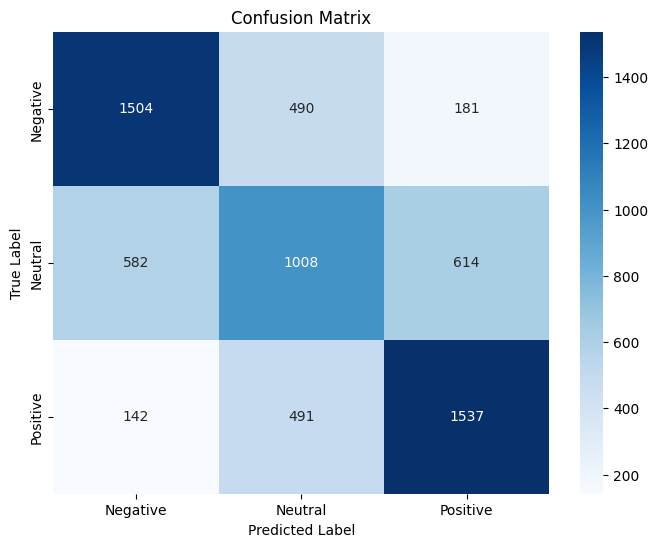

Accuracy: 0.6183
Precision: 0.6131
Recall: 0.6183
F1-Score: 0.6149


In [ ]:
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

## LSTM

In [ ]:
x_train, x_test, y_train, y_test = lstm_split_encode(df)
x_train, x_test = lstm_tok_pad(x_train, x_test)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

lstm = LSTMModel()
print(model.summary())

model = lstm[0]
early_stopping = lstm[1]
history = model.fit(x_train,y_train,epochs=15,batch_size=32,validation_split=0.1,callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 50, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,035,083 (3.95 MB)

 Trainable params: 345,027 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 690,056 (2.63 MB)

None
Epoch 1/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4153 - loss: 1.0408 - val_accuracy: 0.5683 - val_loss: 0.8754
Epoch 2/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6022 - loss: 0.8421 - val_accuracy: 0.5863 - val_loss: 0.8646
Epoch 3/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6714 - loss: 0.7424 - val_accuracy: 0.5763 - val_loss: 0.9036
Epoch 4/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7322 - loss: 0.6360 - val_accuracy: 0.5615 - val_loss: 0.9527
Epoch 5/15
737/737 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7757 - loss: 0.5489 - val_accuracy: 0.5618 - val_loss: 1.0617


205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6087 - loss: 0.8523
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


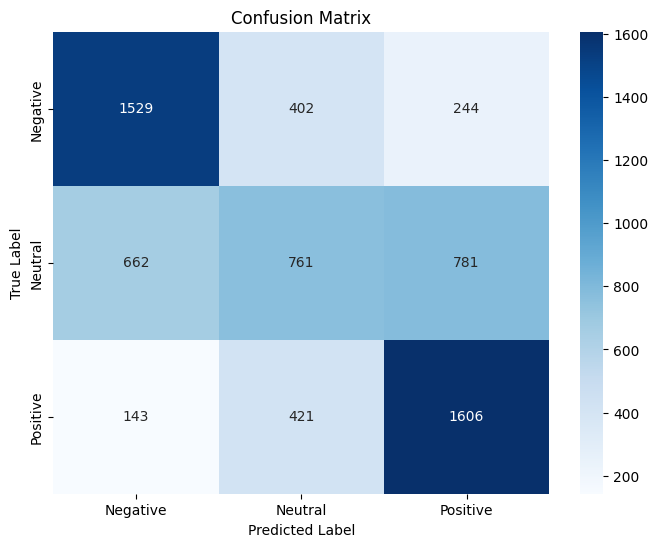

Accuracy: 0.5949
Precision: 0.5815
Recall: 0.5949
F1-Score: 0.5821


In [ ]:
score = model.evaluate(np.asarray(x_test),np.asarray(y_test))
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

## BERT

### Sentiment

In [10]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

filepath = os.path.join(LOC, 'processed')

for filename in os.listdir(filepath):
    if filename.endswith('.tsv'):
        df = open_data(os.path.join(filepath, filename))

        # Load BERTweet tokenizer and model
        # Changed to cardiffnlp/twitter-roberta-base-sentiment for three labels
        tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

        # Create sentiment analysis pipeline with BERTweet
        sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)  # Forced CPU inference

        data = df['body'].astype(str).dropna().tolist()
        dataset = TextDataset(data)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False) # Reduced batch size further

        all_sentiments = []
        all_sentiment_probabilities = []  # New list to store probabilities

        # Wrap the dataloader with tqdm to display a progress bar
        for batch in tqdm(dataloader, desc=f"Processing {filename}", total=len(dataloader)):
            results = sentiment_pipeline(batch, truncation=True, max_length=512) # Set max_length to 512

            for result in results:
                # Modified sentiment assignment logic to accommodate three classes
                if result['label'] == 'LABEL_0':  # Assuming 'LABEL_0' maps to 'NEGATIVE'
                    sentiment_value = -1
                elif result['label'] == 'LABEL_1':  # Assuming 'LABEL_1' maps to 'NEUTRAL'
                    sentiment_value = 0
                else:  # Assuming 'LABEL_2' maps to 'POSITIVE'
                    sentiment_value = 1

                all_sentiments.append(sentiment_value)
                all_sentiment_probabilities.append(result['score'])  # Append the probability

        df['sentiment'] = all_sentiments
        df['sentiment_probability'] = all_sentiment_probabilities  # Add the new column
        df.to_csv(os.path.join(filepath, filename), sep='\t', index=False)

Device set to use cuda:0
Processing 2024-04.tsv: 100%|██████████| 3447/3447 [10:29<00:00,  5.47it/s]
Device set to use cuda:0
Processing 2024-05.tsv: 100%|██████████| 2659/2659 [08:07<00:00,  5.46it/s]
Device set to use cuda:0
Processing 2024-06.tsv: 100%|██████████| 2404/2404 [07:22<00:00,  5.44it/s]
Device set to use cuda:0
Processing 2024-07.tsv: 100%|██████████| 1867/1867 [05:33<00:00,  5.59it/s]
Device set to use cuda:0
Processing 2024-08.tsv: 100%|██████████| 2319/2319 [06:54<00:00,  5.60it/s]
Device set to use cuda:0
Processing 2024-09.tsv: 100%|██████████| 3041/3041 [09:07<00:00,  5.55it/s]
Device set to use cuda:0
Processing 2024-10.tsv: 100%|██████████| 3192/3192 [10:36<00:00,  5.01it/s]
Device set to use cuda:0
Processing 2024-11.tsv: 100%|██████████| 2376/2376 [07:18<00:00,  5.42it/s]
Device set to use cuda:0
Processing 2024-12.tsv: 100%|██████████| 4227/4227 [12:36<00:00,  5.59it/s]
Device set to use cuda:0
Processing 2025-01.tsv: 100%|██████████| 5894/5894 [19:35<00:00,  

In [29]:
filepath = os.path.join(LOC, 'processed')

for filename in os.listdir(filepath):
    if filename.endswith('.tsv'):
        df = open_data(os.path.join(filepath, filename))

        # Ensure numeric conversion
        df['score'] = pd.to_numeric(df['score'], errors='coerce')
        df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')
        df['sentiment_probability'] = pd.to_numeric(df['sentiment_probability'], errors='coerce')

        # Define epsilon for zero-replacement only during computation
        epsilon = 1e-6
        score_safe = np.where(df['score'] == 0, epsilon, df['score'])
        sent_safe = np.where(df['sentiment'] == 0, epsilon, df['sentiment'])
        prob_safe = np.where(df['sentiment_probability'] == 0, epsilon, df['sentiment_probability'])

        df['sent_weight'] = sent_safe * prob_safe * score_safe
        df.to_csv(os.path.join(filepath, filename), sep='\t', index=False)

### Topics

In [ ]:
for filename in os.listdir(filepath):
    if filename.endswith('.tsv'):
        df = open_data(os.path.join(filepath, filename))

        body_texts = df['body'].astype(str).fillna("").tolist()

        try:
            # Fit model and get topic IDs
            topic_ids, _ = topic_model.fit_transform(body_texts)

            # Map topic IDs to top keywords
            topic_strings = []
            for topic_id in topic_ids:
                if topic_id == -1:
                    topic_strings.append("Other")  # -1 means no dominant topic
                else:
                    topic_keywords = topic_model.get_topic(topic_id)
                    top_words = ", ".join([word for word, _ in topic_keywords[:3]])
                    topic_strings.append(top_words)

            # Add to DataFrame
            df['top_topic'] = topic_strings

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            df['top_topic'] = None

        df.to_csv(os.path.join(filepath, filename), sep='\t', index=False)

### Simple NER

In [15]:
CANDIDATE_KEYWORDS = {
    'Trudeau/Carney': ['trudeau', 'justin', 'pm', 'lpc', 'liberals', 'carney', 'mark', 'turdeau', 'sockboy', 'libs'],
    'Singh': ['singh', 'jagmeet', 'ndp', 'democrats'],
    'Poilievre': ['poilievre', 'pierre', 'cpc', 'conservative', 'conservatives', 'pp']
}

def assign_association(text):
    """Assigns association based on candidate keywords in the text."""
    # Convert text to string to handle potential non-string values
    text = str(text)
    for candidate, keywords in CANDIDATE_KEYWORDS.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', text, re.IGNORECASE):
                return candidate
    return ''

filepath = os.path.join(LOC, 'processed')

for filename in os.listdir(filepath):
    if filename.endswith('.tsv'):
        df = open_data(os.path.join(filepath, filename))
        # Ensure 'body' column is of string type before applying assign_association
        df['body'] = df['body'].astype(str)
        df['association'] = df['body'].apply(assign_association)
        df.to_csv(os.path.join(filepath, filename), sep='\t', index=False)

        print(f"Processed: {filename}")

Processed: 2024-04.tsv
Processed: 2024-05.tsv
Processed: 2024-06.tsv
Processed: 2024-07.tsv
Processed: 2024-08.tsv
Processed: 2024-09.tsv
Processed: 2024-10.tsv
Processed: 2024-11.tsv
Processed: 2024-12.tsv
Processed: 2025-01.tsv
Processed: 2025-02.tsv
Processed: 2024-03.tsv


# Analysis

## Mentions of Candidates Over Time

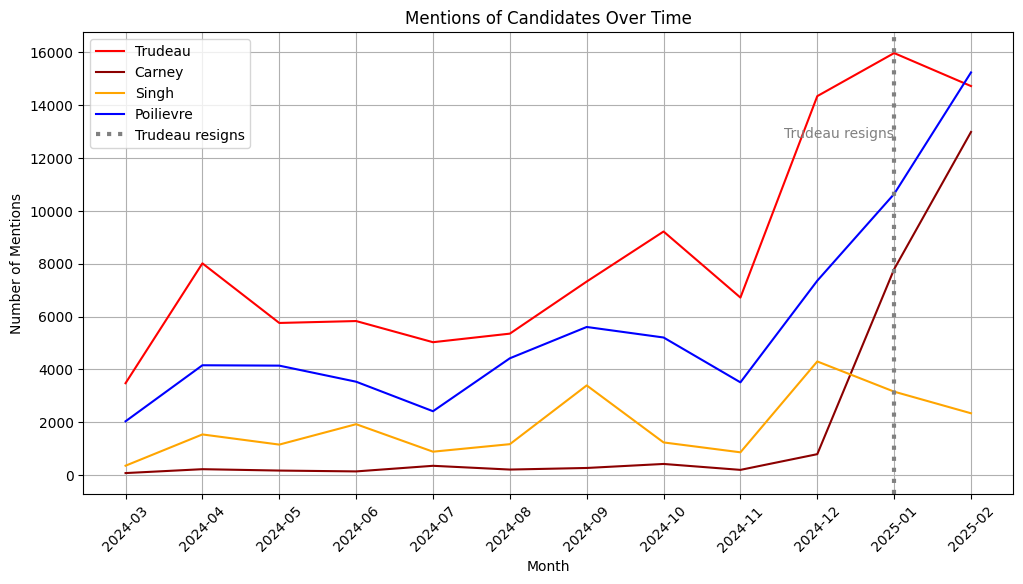

In [ ]:
# Define candidates and their alternative names
CANDIDATE_KEYWORDS = {
    'Trudeau': ['trudeau', 'justin', 'pm', 'trudope', 'jt', 'sockboy'],
    'Carney': ['carney', 'mark'],
    'Singh': ['singh', 'jagmeet'],
    'Poilievre': ['poilievre', 'pierre', 'pp', 'skippy']
}

# Assign colors to each candidate
COLORS = {
    'Trudeau': 'red',  # Liberal
    'Carney': 'darkred',  # Liberal (Alternative)
    'Singh': 'orange',  # NDP
    'Poilievre': 'blue'  # Conservative
}

filepath = os.path.join(LOC, 'processed')

# Define the event date (YYYY-MM format)
EVENT_DATE = '2025-01'
EVENT_LABEL = "Trudeau resigns"

# Store the mentions by date and candidate
mentions = []

for filename in os.listdir(filepath):
    if filename.endswith('.tsv'):
        date_str = filename.split('.')[0]  # Extract date part
        date = datetime.datetime.strptime(date_str, '%Y-%m')  # Parse date as YYYY-MM

        df = open_data(os.path.join(filepath, filename))  # Load data

        # Check for mentions of each candidate using all their alternative names
        for candidate, keywords in CANDIDATE_KEYWORDS.items():
            pattern = r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'
            mentions_count = df['body'].str.contains(pattern, case=False, na=False, regex=True).sum()
            mentions.append({'date': date, 'candidate': candidate, 'mentions': mentions_count})

# Convert mentions to a DataFrame
mentions_df = pd.DataFrame(mentions)

# Convert 'date' to a monthly period for grouping
mentions_df['month'] = mentions_df['date'].dt.to_period('M')

# Group by month and candidate, summing the mentions
monthly_mentions = mentions_df.groupby(['month', 'candidate'])['mentions'].sum().reset_index()

# Pivot table to make 'candidate' the columns for easy plotting
pivot_df = monthly_mentions.pivot_table(index='month', columns='candidate', values='mentions', fill_value=0)

# Plot each candidate's mentions over time with assigned colors
plt.figure(figsize=(12, 6))
for candidate in CANDIDATE_KEYWORDS.keys():
    plt.plot(pivot_df.index.astype(str), pivot_df[candidate], label=candidate, color=COLORS[candidate])

# Add a light gray dotted vertical line for the event
plt.axvline(EVENT_DATE, color='gray', linestyle='dotted', linewidth=3, label=EVENT_LABEL)

# Add text annotation for the event
plt.text(EVENT_DATE, pivot_df.max().max() * 0.8, EVENT_LABEL, color='gray', fontsize=10, ha='right')

plt.title('Mentions of Candidates Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Mentions by Party Over Time

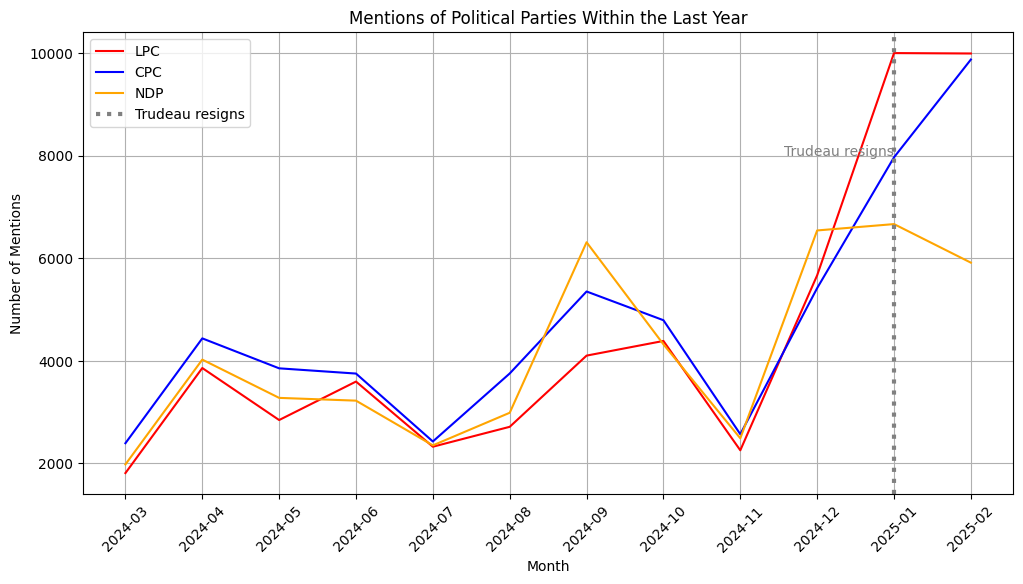

In [ ]:
PARTY_KEYWORDS = {
    'LPC': ['liberal', 'libs', 'lpc'],
    'CPC': ['conservative', 'tory', 'tories', 'pc', 'cpc'],
    'NDP': ['ndp', 'new democratic', 'new democrats']
}

# Assign colors to each party
COLORS = {
    'LPC': 'red',
    'CPC': 'blue',
    'NDP': 'orange'
}

filepath = os.path.join(LOC, 'processed')

# Define the event date
EVENT_DATE = '2025-01'
EVENT_LABEL = "Trudeau resigns"

# Store the mentions by date and party
mentions = []

for filename in os.listdir(filepath):
    if filename.endswith('.tsv'):
        date_str = filename.split('.')[0]  # Extract date part
        date = datetime.datetime.strptime(date_str, '%Y-%m')  # Parse date as YYYY-MM

        df = open_data(os.path.join(filepath, filename))  # Load data

        # Check for mentions of each party using all its keywords
        for party, keywords in PARTY_KEYWORDS.items():
            # Create a regex pattern that matches any of the keywords
            pattern = r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'
            mentions_count = df['body'].str.contains(pattern, case=False, na=False, regex=True).sum()

            mentions.append({'date': date, 'party': party, 'mentions': mentions_count})

# Convert mentions to a DataFrame
mentions_df = pd.DataFrame(mentions)

# Convert 'date' to a monthly period for grouping
mentions_df['month'] = mentions_df['date'].dt.to_period('M')

# Group by month and party, summing the mentions
monthly_mentions = mentions_df.groupby(['month', 'party'])['mentions'].sum().reset_index()

# Pivot table to make 'party' the columns for easy plotting
pivot_df = monthly_mentions.pivot_table(index='month', columns='party', values='mentions', fill_value=0)

# Plot each party's mentions over time with assigned colors
plt.figure(figsize=(12, 6))
for party in PARTY_KEYWORDS.keys():
    plt.plot(pivot_df.index.astype(str), pivot_df[party], label=party, color=COLORS[party])

# Add a light gray dotted vertical line for the event
plt.axvline(EVENT_DATE, color='gray', linestyle='dotted', linewidth=3, label=EVENT_LABEL)

# Add text annotation for the event
plt.text(EVENT_DATE, pivot_df.max().max() * 0.8, EVENT_LABEL, color='gray', fontsize=10, ha='right')

plt.title('Mentions of Political Parties Within the Last Year')
plt.xlabel('Month')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Topic Modelling Over Time
We apply topic modelling to the posts to see which topics gather the greatest attention over each month.

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
monthly_topics = {}

filepath = os.path.join(LOC, 'processed')
for filename in os.listdir(filepath):
    if filename.endswith('.tsv'):
        date_str = filename.split('.')[0]
        date = datetime.datetime.strptime(date_str, '%Y-%m')

        df = open_data(os.path.join(filepath, filename))
        comments = df['body'].astype(str).tolist()
        embeddings = embedding_model.encode(comments, show_progress_bar=True)

        topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_cluster)
        topics, _ = topic_model.fit_transform(comments, embeddings)

        topic_freq = topic_model.get_topic_freq()
        top_topics = topic_freq.iloc[1:5]  # Get top 5 topics (exclude -1 if it's the outlier)

        topic_labels = {}
        for topic in top_topics['Topic']:
            top_words = topic_model.get_topic(topic)[:10]  # Top 10 words for the topic
            topic_label = ", ".join([word[0] for word in top_words])  # Inferred label from top words
            topic_labels[topic] = topic_label

        # Store monthly data with topic frequency and inferred labels
        monthly_topics[date_str] = []
        for topic in top_topics[['Topic', 'Count']].to_dict(orient='records'):
            topic_info = topic.copy()
            topic_info['Label'] = topic_labels[topic['Topic']]
            monthly_topics[date_str].append(topic_info)

for month, topics in sorted(monthly_topics.items()):
    print(f"\n{month}:")
    for topic in topics:
        print(f"  - Topic {topic['Topic']}: {topic['Label']} ({topic['Count']} occurrences)")

Batches:   0%|          | 0/815 [00:00<?, ?it/s]

Batches:   0%|          | 0/1724 [00:00<?, ?it/s]

Batches:   0%|          | 0/1330 [00:00<?, ?it/s]

Batches:   0%|          | 0/1202 [00:00<?, ?it/s]

Batches:   0%|          | 0/934 [00:00<?, ?it/s]

Batches:   0%|          | 0/1160 [00:00<?, ?it/s]

Batches:   0%|          | 0/1521 [00:00<?, ?it/s]

Batches:   0%|          | 0/1596 [00:00<?, ?it/s]

Batches:   0%|          | 0/1188 [00:00<?, ?it/s]

Batches:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/2947 [00:00<?, ?it/s]

Batches:   0%|          | 0/3398 [00:00<?, ?it/s]


2024-03:
  - Topic 0: israel, hamas, palestinians, palestine, gaza, palestinian, jews, jewish, israeli, land (1384 occurrences)
  - Topic 1: ndp, liberals, libs, voters, vote, party, liberal, coalition, chance, election (541 occurrences)
  - Topic 2: conservatives, conservative, liberal, liberals, vote, blame, rid, worse, win, voters (466 occurrences)
  - Topic 3: immigration, immigrants, students, visa, tfws, tie, number, population, immigrant, skilled (416 occurrences)

2024-04:
  - Topic 0: maker, linerals, wohld, wtaf, hezzbolah, catharines, backbone, hop, ndp, leftism (141 occurrences)
  - Topic 1: poilievre, pointy, cockiness, gauche, gaine, kristi, preprogrammed, poiliever, noem, tryhard (133 occurrences)
  - Topic 2: hamas, gaza, civilians, israel, innocent, qatar, surrender, palestinians, kill, israeli (128 occurrences)
  - Topic 3: chf, tonne, revenues, murphy, cleaners, rex, increate, taxfoundation, eur, compensator (111 occurrences)

2024-05:
  - Topic 0: monsters, praise,

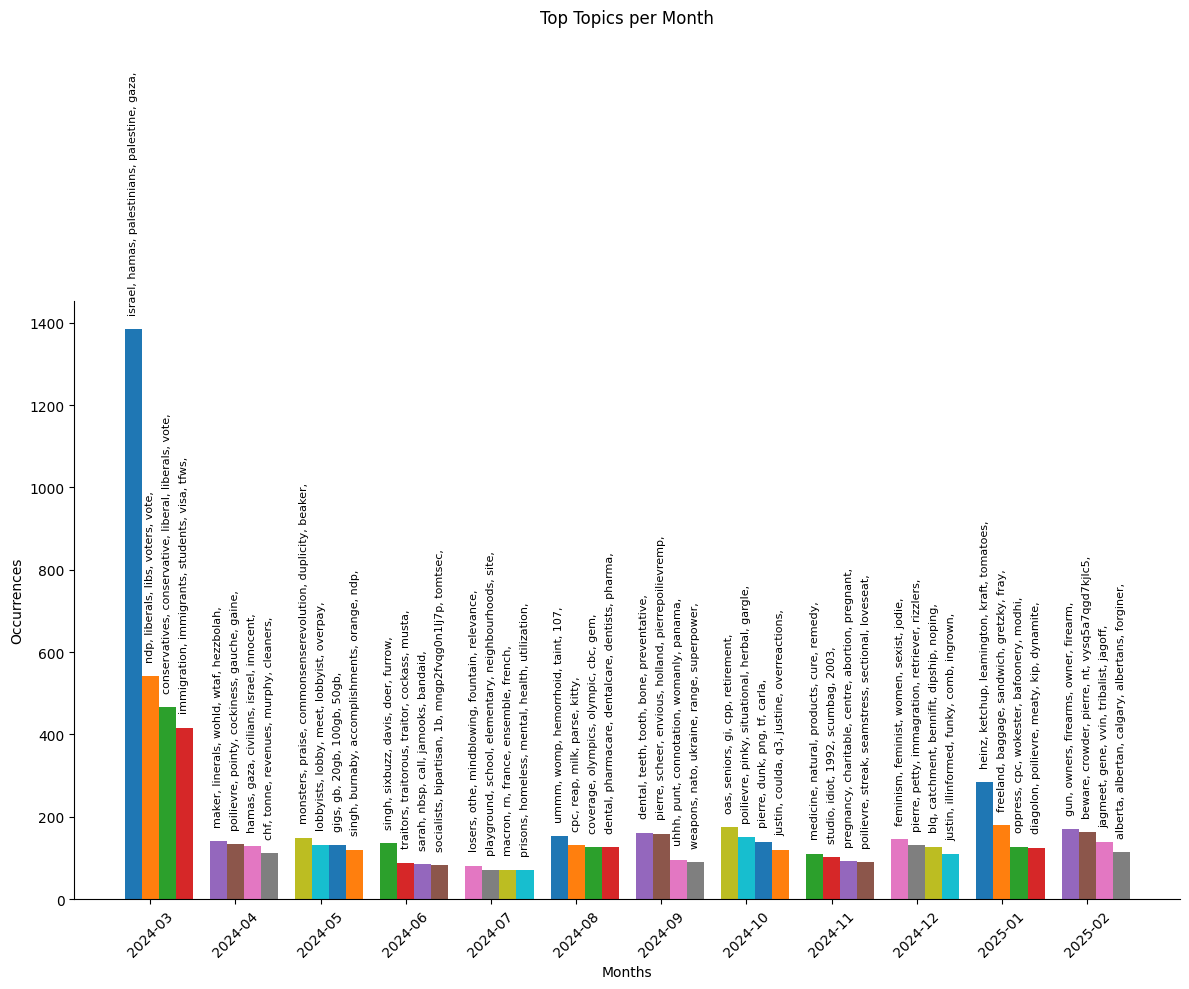

In [ ]:
months = []
topic_labels = []
topic_counts = []

for month, topics in sorted(monthly_topics.items()):
    months.append(month)

    for topic in topics:
        truncated_label = ' '.join(topic['Label'].split()[:5])
        topic_labels.append(truncated_label)
        topic_counts.append(topic['Count'])

fig, ax = plt.subplots(figsize=(12, 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

topics_per_month = 4
bar_width = 0.2
index = np.arange(len(months))

for i, month in enumerate(sorted(monthly_topics.keys())):
    month_topics = monthly_topics[month]
    for j, topic in enumerate(month_topics):
        ax.bar(index[i] + j * bar_width, topic['Count'], bar_width, label=topic['Label'])

for i, month in enumerate(sorted(monthly_topics.keys())):
    for j, topic in enumerate(monthly_topics[month]):
        ax.text(
            index[i] + j * bar_width,
            topic['Count'] + 40,
            topic_labels[i * len(monthly_topics[month]) + j],
            ha='center',
            rotation=90,
            fontsize=8,
        )

ax.set_xlabel('Months')
ax.set_ylabel('Occurrences')
ax.set_title('Top Topics per Month', pad=200)
ax.set_xticks(index + bar_width * (topics_per_month / 2 - 1))
ax.set_xticklabels(months, rotation=45)
plt.subplots_adjust(bottom=0.15, top=0.9)

plt.tight_layout()
plt.show()

## Sentiment Impressions Over Time
Total sentiment impressions of candidates per month.

In [22]:
SENTIMENT_COLORS = {
    -1: 'red',  # Negative
    0: 'gray',  # Neutral
    1: 'green'  # Positive
}

def plot_sentiment_over_time(association_name, filepath=os.path.join(LOC, 'processed')):
    """Plots sentiment impressions over time for a given association."""

    sentiments = []

    for filename in os.listdir(filepath):
        if filename.endswith('.tsv'):
            date_str = filename.split('.')[0]
            date = datetime.datetime.strptime(date_str, '%Y-%m')

            df = open_data(os.path.join(filepath, filename))

            # Filter for the specified association
            filtered_df = df[df['association'] == association_name]

            # Calculate sentiment counts
            for sentiment_value in [-1, 0, 1]:
                count = filtered_df[filtered_df['sentiment'] == sentiment_value]['sentiment'].count()
                sentiments.append({'date': date, 'sentiment': sentiment_value, 'count': count})

    # Convert sentiments to DataFrame and process for plotting
    sentiments_df = pd.DataFrame(sentiments)
    sentiments_df['month'] = sentiments_df['date'].dt.to_period('M')
    monthly_sentiments = sentiments_df.groupby(['month', 'sentiment'])['count'].sum().reset_index()
    pivot_df = monthly_sentiments.pivot_table(index='month', columns='sentiment', values='count', fill_value=0)

    # Plot sentiments
    plt.figure(figsize=(12, 6))
    for sentiment_value, color in SENTIMENT_COLORS.items():
        # Custom label names:
        if sentiment_value == -1:
            label = 'Negative'
        elif sentiment_value == 0:
            label = 'Neutral'
        else:
            label = 'Positive'

        plt.plot(pivot_df.index.astype(str), pivot_df[sentiment_value], label=label, color=color)

    plt.title(f'Sentiment Impressions for {association_name} Over Time')
    plt.xlabel('Month')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

#### Trudeau / Carney

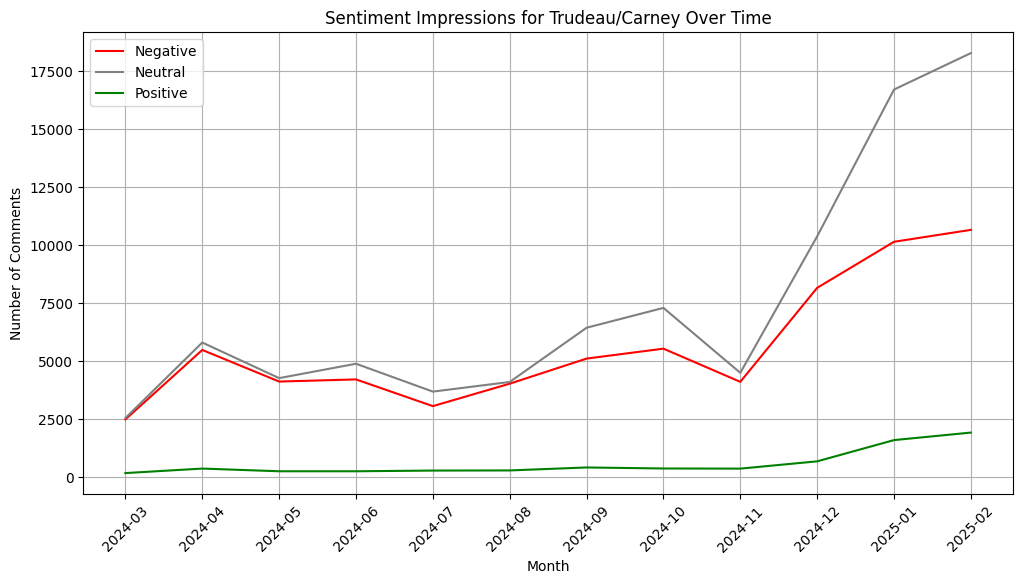

In [23]:
plot_sentiment_over_time('Trudeau/Carney')

#### Poilievre

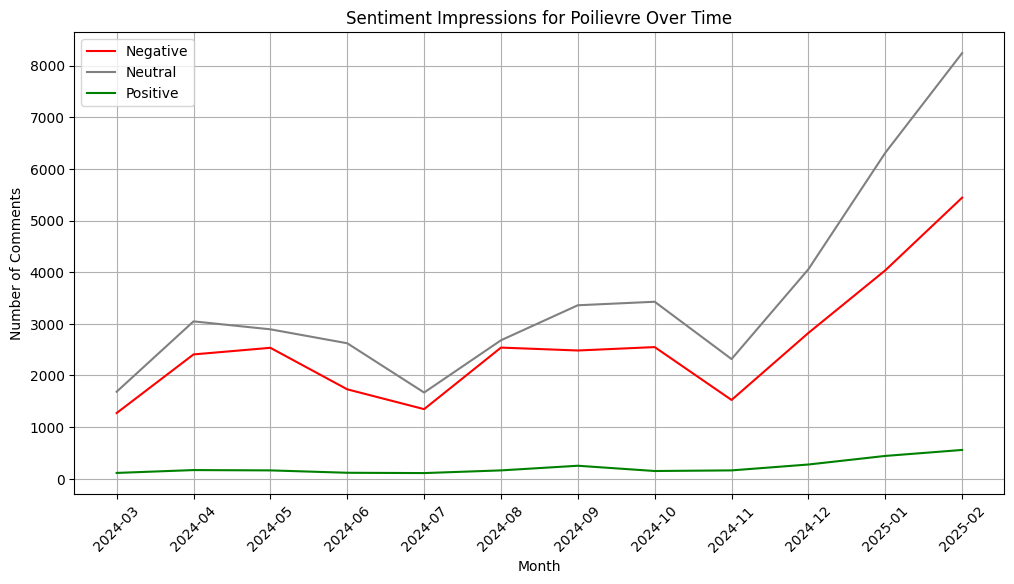

In [24]:
plot_sentiment_over_time('Poilievre')

#### Singh

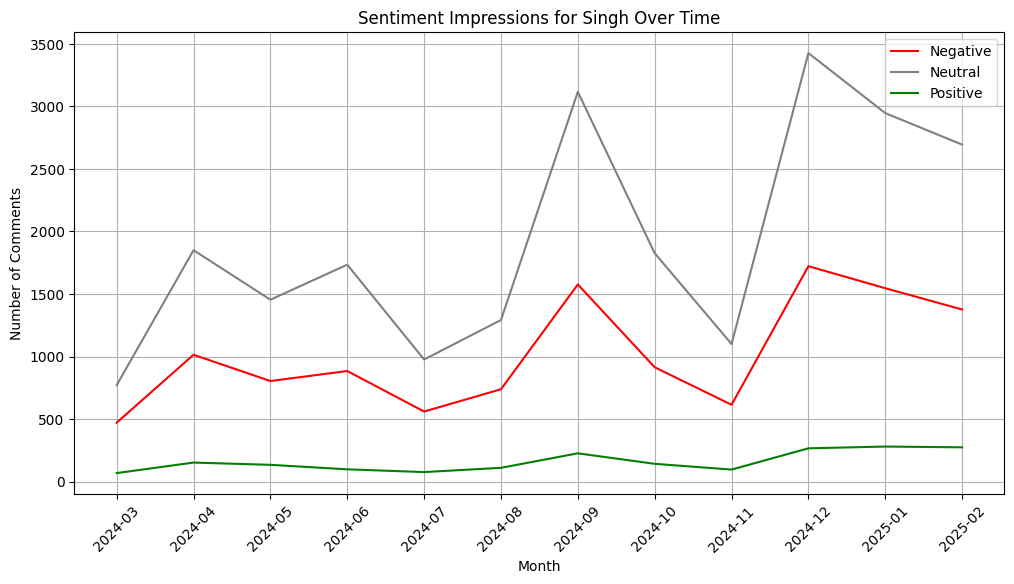

In [25]:
plot_sentiment_over_time('Singh')

## Weighted Sentiment Impressions

In [32]:
SENTIMENT_COLORS = {
    -1: 'red',  # Negative
    0: 'gray',  # Neutral
    1: 'green'  # Positive
}

def plot_wsentiment_over_time(association_name, filepath=os.path.join(LOC, 'processed')):
    """Plots sentiment impressions over time for a given association using sent_weight."""

    sentiments = []

    for filename in os.listdir(filepath):
        if filename.endswith('.tsv'):
            date_str = filename.split('.')[0]
            date = datetime.datetime.strptime(date_str, '%Y-%m')

            df = open_data(os.path.join(filepath, filename))

            # Filter for the specified association
            filtered_df = df[df['association'] == association_name]

            # Calculate weighted sentiment sum for each sentiment value
            for sentiment_value in [-1, 0, 1]:
                # Take the absolute value of 'sent_weight' before summing
                weighted_sentiment_sum = filtered_df[filtered_df['sentiment'] == sentiment_value]['sent_weight'].abs().sum()
                sentiments.append({'date': date, 'sentiment': sentiment_value, 'weighted_sentiment': weighted_sentiment_sum})

    # Convert sentiments to DataFrame and process for plotting
    sentiments_df = pd.DataFrame(sentiments)
    sentiments_df['month'] = sentiments_df['date'].dt.to_period('M')
    monthly_sentiments = sentiments_df.groupby(['month', 'sentiment'])['weighted_sentiment'].sum().reset_index()
    pivot_df = monthly_sentiments.pivot_table(index='month', columns='sentiment', values='weighted_sentiment', fill_value=0)

    # Plot sentiments
    plt.figure(figsize=(12, 6))
    for sentiment_value, color in SENTIMENT_COLORS.items():
        # Custom label names:
        if sentiment_value == -1:
            label = 'Negative'
        elif sentiment_value == 0:
            label = 'Neutral'
        else:
            label = 'Positive'

        plt.plot(pivot_df.index.astype(str), pivot_df[sentiment_value], label=label, color=color)

    plt.title(f'Weighted Sentiment Impressions for {association_name} Over Time')
    plt.xlabel('Month')
    plt.ylabel('Weighted Sentiment Sum')  # Update y-axis label
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

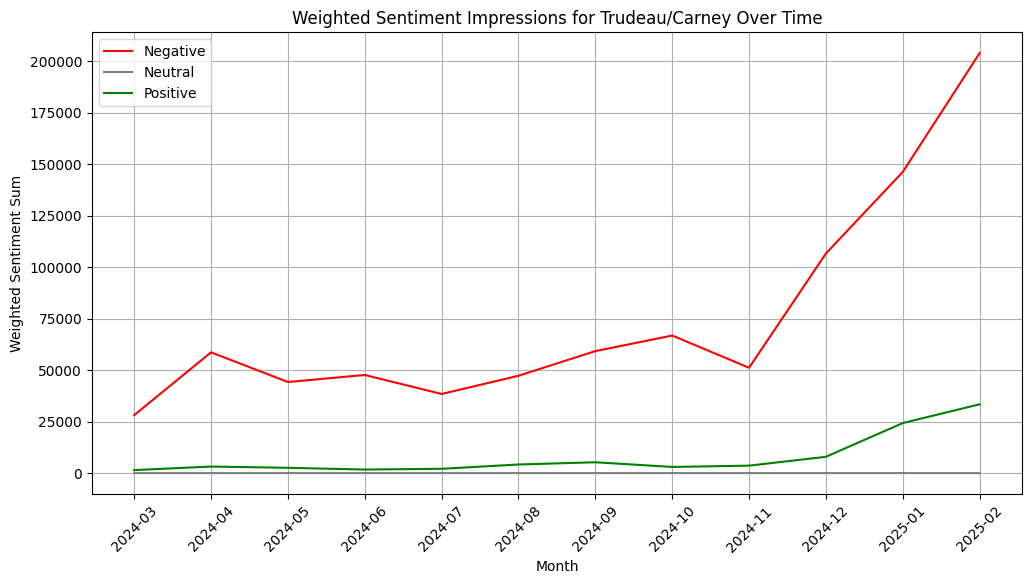

In [33]:
plot_wsentiment_over_time('Trudeau/Carney')

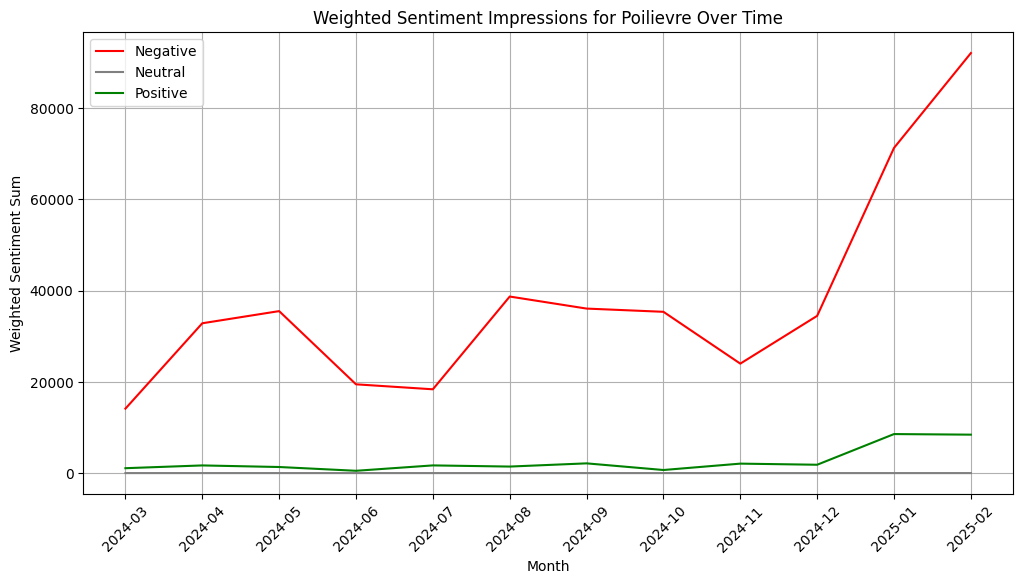

In [34]:
plot_wsentiment_over_time('Poilievre')

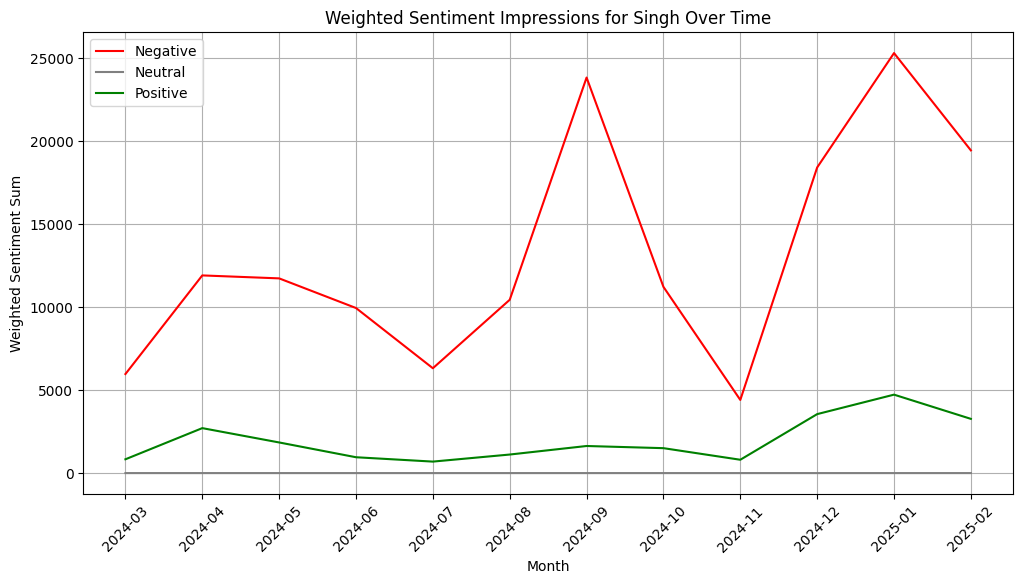

In [35]:
plot_wsentiment_over_time('Singh')

## Topic-to-Candidate Sentiment Over Time

In [40]:
from collections import defaultdict

SENTIMENT_COLORS = {
    -1: 'red',  # Negative
    0: 'gray',  # Neutral
    1: 'green'  # Positive
}

def plot_topic_sentiment_over_time(association_name, keywords, filepath=os.path.join(LOC, 'processed')):
    """
    Plots sentiment over time for comments associated with a given entity and containing specific keywords in their topics.

    Args:
        association_name (str): The name of the entity (e.g., "Trudeau/Carney").
        keywords (list): A list of keywords to filter topics.
        filepath (str, optional): The path to the processed data files. Defaults to os.path.join(LOC, 'processed').
    """

    monthly_sentiments = defaultdict(lambda: defaultdict(int))

    for filename in os.listdir(filepath):
        if filename.endswith('.tsv'):
            date_str = filename.split('.')[0]
            date = datetime.datetime.strptime(date_str, '%Y-%m')

            df = open_data(os.path.join(filepath, filename))

            # Filter for the specified association and keywords in topics
            filtered_df = df[
                (df['association'] == association_name) &
                df['top_topic'].str.contains('|'.join(keywords), case=False, na=False)
            ]

            # Count sentiments for the filtered data
            for sentiment_value in [-1, 0, 1]:
                count = filtered_df[filtered_df['sentiment'] == sentiment_value]['sentiment'].count()
                monthly_sentiments[date.strftime('%Y-%m')][sentiment_value] += count

    # Prepare data for plotting
    months = sorted(monthly_sentiments.keys())
    sentiment_counts = {sentiment: [monthly_sentiments[month][sentiment] for month in months]
                        for sentiment in [-1, 0, 1]}

    # Plot sentiments
    plt.figure(figsize=(12, 6))
    for sentiment_value, color in SENTIMENT_COLORS.items():
        label = 'Negative' if sentiment_value == -1 else 'Neutral' if sentiment_value == 0 else 'Positive'
        plt.plot(months, sentiment_counts[sentiment_value], label=label, color=color)

    plt.title(f'Sentiment Over Time for {association_name} with Topics Containing: {", ".join(keywords)}')
    plt.xlabel('Month')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

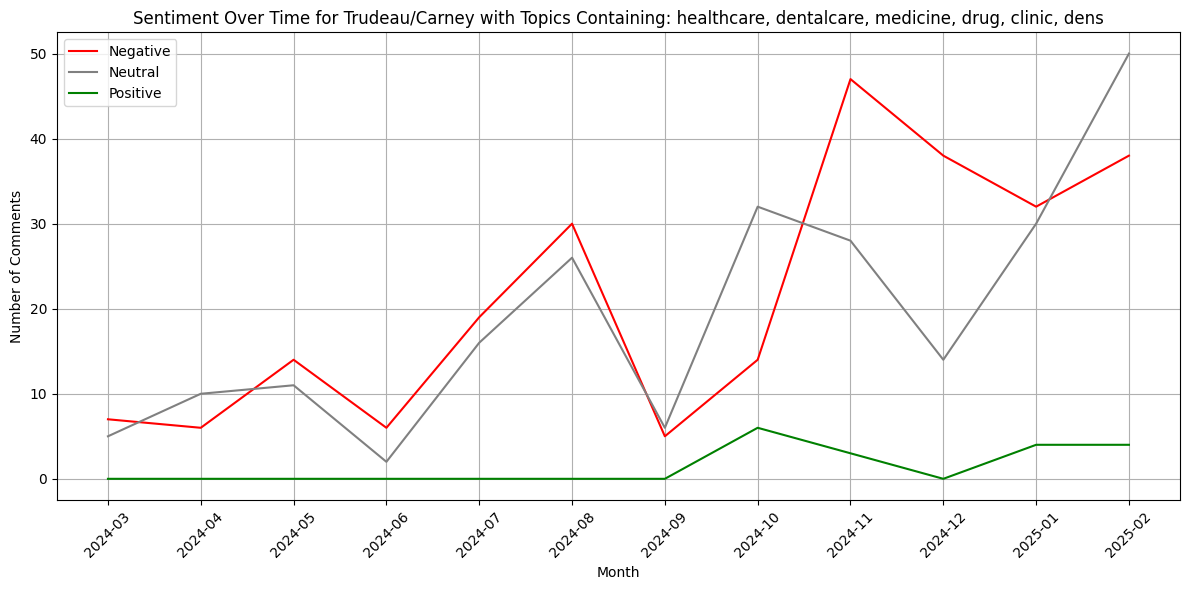

In [41]:
plot_topic_sentiment_over_time('Trudeau/Carney', ['healthcare', 'dentalcare', 'medicine', 'drug', 'clinic', 'dens'])

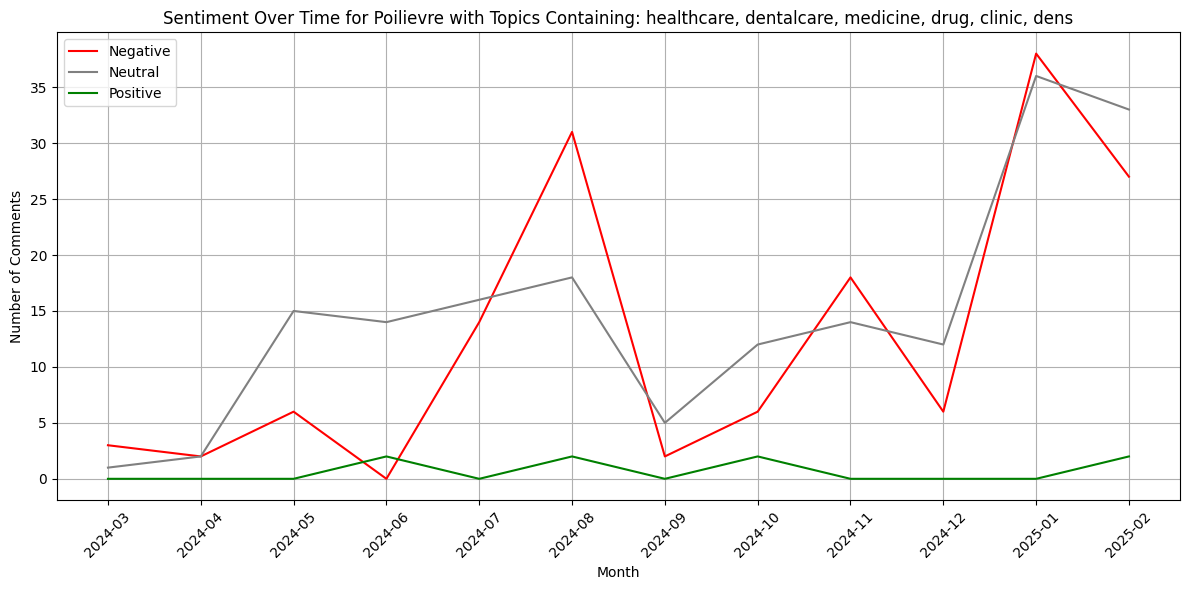

In [42]:
plot_topic_sentiment_over_time('Poilievre', ['healthcare', 'dentalcare', 'medicine', 'drug', 'clinic', 'dens'])

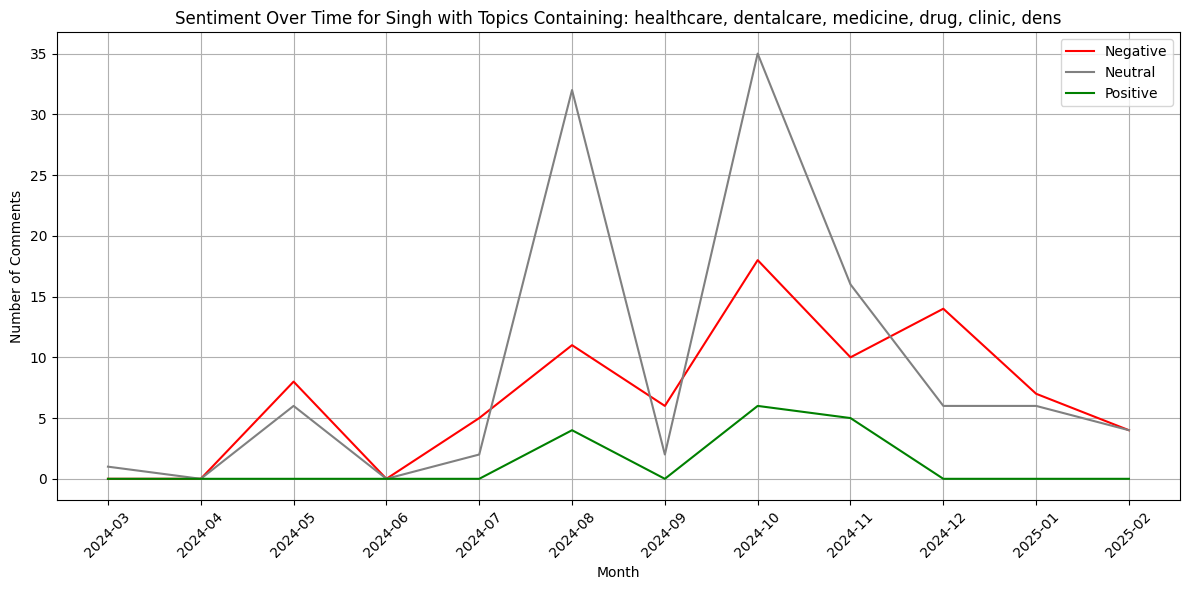

In [43]:
plot_topic_sentiment_over_time('Singh', ['healthcare', 'dentalcare', 'medicine', 'drug', 'clinic', 'dens'])